In [1]:
import sys
sys.path.append('./cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms


transform_test = transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


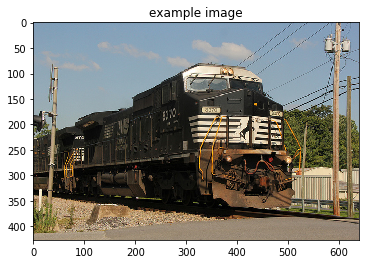

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Load Trained Models



In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN


encoder_file = 'encoder-2.pkl'
decoder_file = 'decoder-2.pkl'


embed_size = 256
hidden_size = 512


vocab_size = len(data_loader.dataset.vocab)


encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()


encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))


encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 32244129.22it/s]


DecoderRNN(
  (embed): Embedding(8855, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8855, bias=True)
)

In [5]:

image = image.to(device)


features = encoder(image).unsqueeze(1)


output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 854, 39, 3, 1902, 79, 3, 522, 1, 1, 18, 1, 498]


<a id='step4'></a>
## Index2Words



In [30]:
def clean_sentence(output):
    sentence = []
    for i in range(len(output)):
        vocab_id = output[i]
        word = data_loader.dataset.vocab.idx2word[vocab_id]
        if word == data_loader.dataset.vocab.end_word:
            break
        if word != data_loader.dataset.vocab.start_word:
            sentence.append(word)
    sentence = " ".join(sentence)
    return sentence

In [31]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a train on a track near a building


In [32]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

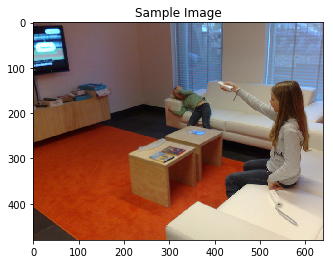

a living room with a couch and a tv


In [33]:
get_prediction()

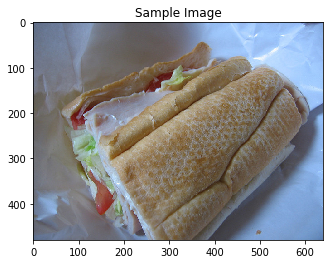

a plate of food with a salad and a sandwich .


In [36]:
get_prediction()

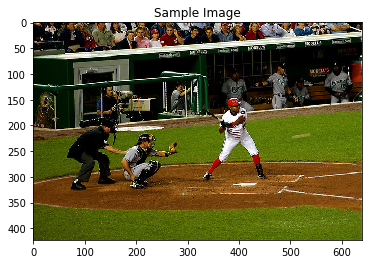

a baseball player swinging a bat at a ball


In [44]:
get_prediction()

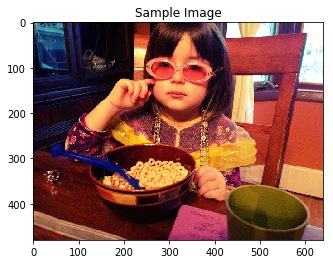

a man is eating a hot dog in a bun .


In [45]:
get_prediction()